### Abstract

In this notebook, we investigate two key network centrality measures: betweenness centrality and closeness centrality. Ideally, these
metrics help identify critical road segments for policy intervention. Betweenness centrality quantifies how often a road segment appears on the shortest paths between all location pairs. Closeness centrality measures how efficiently a road segment connects to all other locations. 

The effectiveness of capacity reduction policies in inducing a mode shift depends on the network role of the affected roads. Roads with high betweenness centrality serve as critical corridors for through traffic. Reducing capacity on these roads can lead to significant rerouting and increased congestion unless alternative high-capacity public transport options are available. In contrast, roads with high closeness centrality are well-connected within the local network, making them better candidates for capacity reductions that encourage active transport. Since these roads primarily serve short-distance trips, reallocating space for cycling and walking is more feasible and can promote mode shift without increasing travel time. However, successful implementation requires ensuring that viable alternatives exist, including dedicated infrastructure for active modes and efficient public transport connections. Thus, high-closeness roads in dense urban areas with multimodal accessibility are optimal targets for capacity reduction policies aimed at sustainable transport transitions.

It is therefore a reasonable hypothesis that capacity reductions inducing mode shift should primarily be focused on roads with low betweenness centrality and roads with high closeness centrality. 

In this notebook, we investigate these measures with real-world data.

The steps are the following:
1. Load the Munich road network from OpenStreetMap, using osmnx.
2. Define and compute centrality measures for road segments.
3. Find out how many roads fulfill these criteria: high closeness centraliy and low betweeness centrality. 
4. Investigate the relationship from this to road types, i.e. primary, secondary, tertiary, etc. Are all road types similarly affect, where are the differences? Investigate the two centrality measures separated.  


In [78]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter, defaultdict

### Import necessary packages

In [57]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm

plt.rcParams["font.family"] = "Times New Roman"

### Download the multi-graph from ox

In [25]:
# Define the location
# TODO: change to Munich, Germany
place_name = "Aschaffenburg, Germany"

# Download the street network (driveable roads)
G = ox.graph_from_place(place_name, network_type="drive")

### Computation of betweenness centrality and closeness centrality for edges of the city

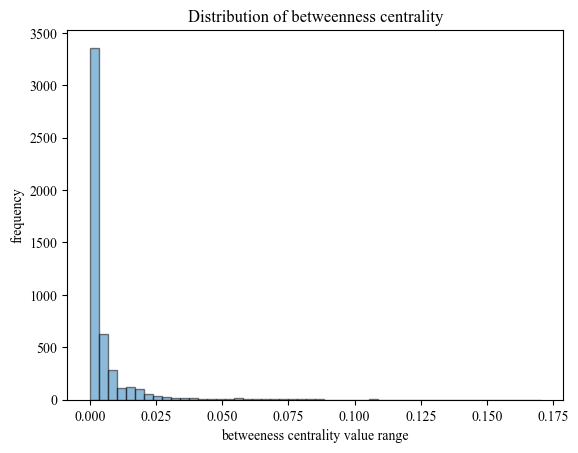

In [26]:
# Compute betweenness centrality
betweenness = nx.edge_betweenness_centrality(G)

values = list(betweenness.values())

plt.hist(values, bins=50, edgecolor="black", alpha=0.5)
plt.xlabel("betweeness centrality value range")
plt.ylabel("frequency")
plt.title("Distribution of betweenness centrality")
plt.show()

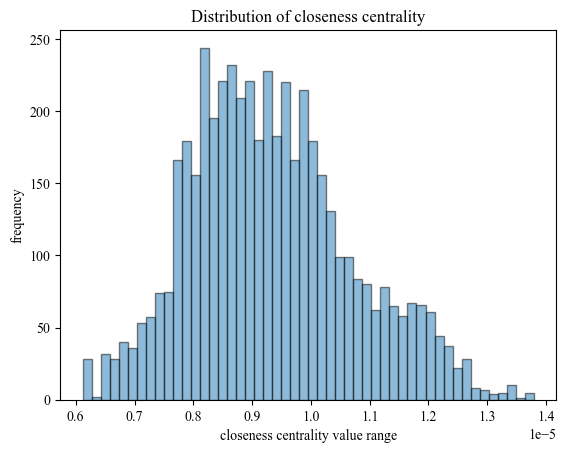

In [27]:
def edge_closeness_centrality(G):
    # Initialize an empty dictionary to store edge centralities
    edge_closeness = {}

    # Iterate through each edge in the graph
    for u, v, k in G.edges(keys=True):
        # Calculate the total distance from node u and node v to all other nodes
        dist_u = nx.single_source_shortest_path_length(G, u)
        dist_v = nx.single_source_shortest_path_length(G, v)

        # Calculate the closeness centrality for the edge (u, v)
        total_distance = 0
        num_nodes = len(G.nodes())
        for node in G.nodes():
            # Skip nodes where the distance is inf (disconnected nodes)
            if node != u and node != v:
                total_distance += dist_u.get(node, np.inf) + dist_v.get(node, np.inf)

        # The closeness centrality of the edge is inversely proportional to the total distance
        edge_closeness[(u, v, k)] = 1 / total_distance if total_distance > 0 else 0

    return edge_closeness


# Compute closeness centrality
closeness = edge_closeness_centrality(G)

values = list(closeness.values())

plt.hist(values, bins=50, edgecolor="black", alpha=0.5)
plt.xlabel("closeness centrality value range")
plt.ylabel("frequency")
plt.title("Distribution of closeness centrality")
plt.show()

In [28]:
# Add centrality measures as node attributes
nx.set_edge_attributes(G, betweenness, "betweenness_centrality")
nx.set_edge_attributes(G, closeness, "closeness_centrality")

### Computation of normalized betweenness and closeness

Our goal is to identify roads with high closeness centrality and low betweenness centrality. To ensure both metrics follow a "higher is better" convention, we normalize and invert betweenness.

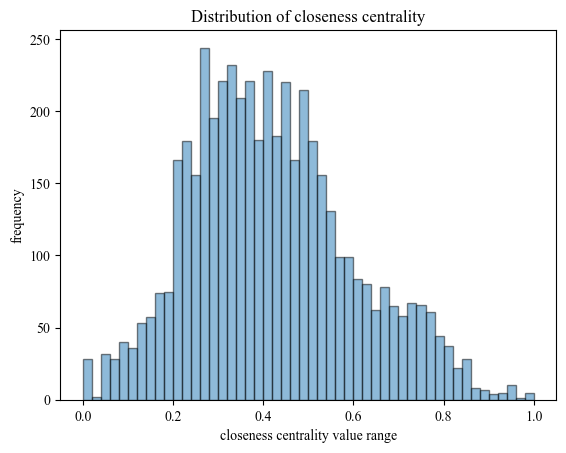

In [ ]:
# Extract values while keeping the node associations
betweenness_values = np.array(list(betweenness.values()))
closeness_values = np.array(list(closeness.values()))

# Normalize the values
betweenness_min, betweenness_max = betweenness_values.min(), betweenness_values.max()
closeness_min, closeness_max = closeness_values.min(), closeness_values.max()

betweenness_norm = {
    node: (1 - ((val - betweenness_min) / (betweenness_max - betweenness_min)))
    for node, val in betweenness.items()
}

closeness_norm = {
    node: ((val - closeness_min) / (closeness_max - closeness_min))
    for node, val in closeness.items()
}


# Set normalized attributes in the graph
nx.set_edge_attributes(G, betweenness_norm, "betweenness_norm")
nx.set_edge_attributes(G, closeness_norm, "closeness_norm")

### Visualization of values of betweenness and closeness on the map 

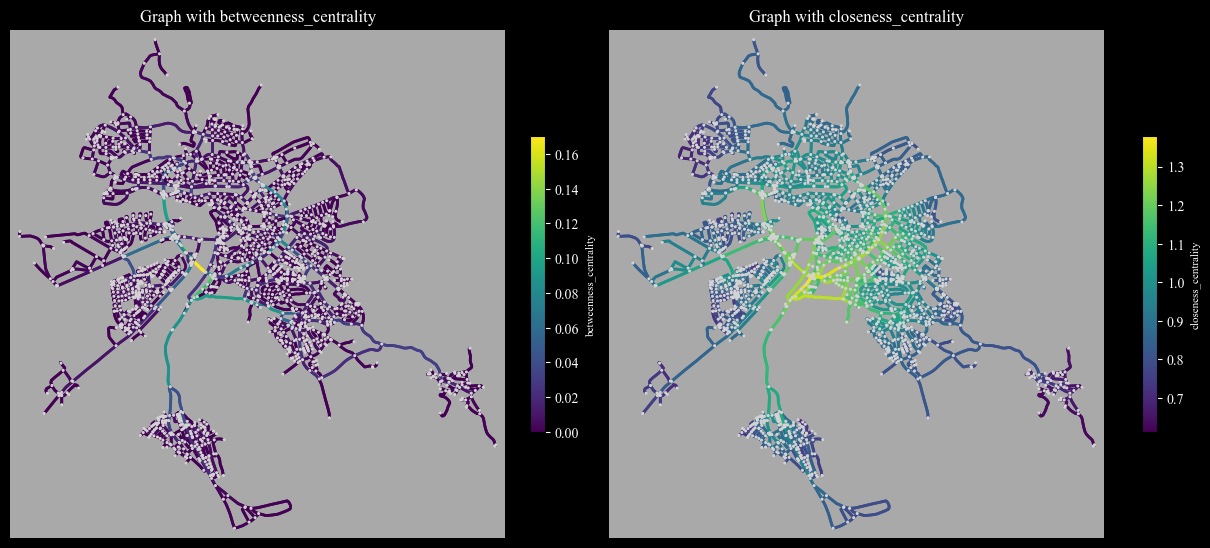

In [ ]:
def plot_graph_with_edge_colorbar(ax, G, centrality_type):
    edge_values = [data.get(centrality_type, 0) for _, _, data in G.edges(data=True)]

    cmap = plt.cm.viridis
    norm = Normalize(vmin=min(edge_values), vmax=max(edge_values))
    edge_colors = [cmap(norm(value)) for value in edge_values]

    # Plot on the provided ax
    ox.plot_graph(
        G,
        ax=ax,
        node_color="lightgray",
        edge_color=edge_colors,
        edge_linewidth=2,
        node_size=5,
        show=False,
        close=False,
    )
    ax.set_facecolor("darkgray")
    ax.set_title(f"Graph with {centrality_type}", color="white")

    # Create a colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, shrink=0.5, ax=ax)
    cbar.set_label(f"{centrality_type}", fontsize=8, color="white")
    cbar.ax.yaxis.set_tick_params(color="white")
    plt.setp(cbar.ax.get_yticklabels(), color="white")


# Create figure with two subplots
fig, axes = plt.subplots(
    1, 2, figsize=(12, 6), constrained_layout=True, facecolor="black"
)

plot_graph_with_edge_colorbar(axes[0], G, "betweenness_centrality")
plot_graph_with_edge_colorbar(axes[1], G, "closeness_centrality")

plt.show()

### Road typeslist:

1. **unclassified** – Minor roads that don't fall into a specific category; often local access roads in rural or suburban areas.  
2. **living_street** – Residential streets where pedestrians have priority, often with traffic-calming measures and very low speed limits.  
3. **residential** – Roads primarily serving residential neighborhoods, typically with low traffic and speed limits.  
4. **primary** – Major roads that form the main arteries of a road network, carrying significant through traffic between cities or districts.  
5. **trunk** – High-capacity roads that are just below motorways in hierarchy, often serving as regional connectors with limited access points.  
6. **tertiary** – Roads connecting smaller settlements or neighborhoods, carrying moderate traffic but not as significant as secondary roads.  
7. **tertiary_link** – Short roads connecting tertiary roads to other road categories, like ramps or small connecting streets.  
8. **secondary** – Roads serving medium-distance travel between towns or major districts within a city.  
9. **secondary_link** – Connecting roads that link secondary roads to other road categories, often ramps or minor junction roads.  
10. **primary_link** – Short roads or ramps connecting primary roads to other roads, often used in highway interchanges.  
11. **trunk_link** – Connecting roads linking trunk roads to other road types, often found in major highway interchanges.  

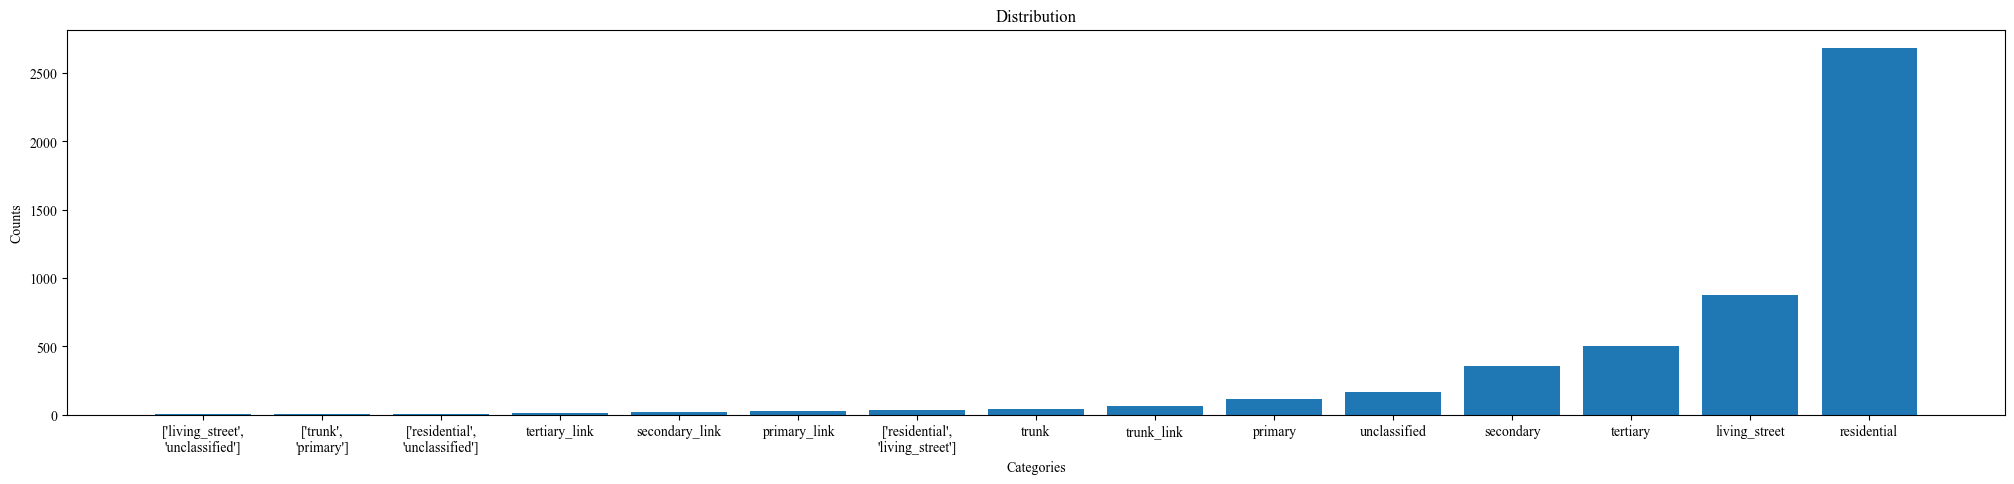

dict_keys(["['living_street',\n'unclassified']", "['trunk',\n'primary']", "['residential',\n'unclassified']", 'tertiary_link', 'secondary_link', 'primary_link', "['residential',\n'living_street']", 'trunk', 'trunk_link', 'primary', 'unclassified', 'secondary', 'tertiary', 'living_street', 'residential'])


In [31]:
# all type of highway
highway_type = dict()
for _, _, data in G.edges(data=True):
    highway = str(data.get("highway")).replace(" ", "\n")
    if highway not in highway_type:
        highway_type[highway] = 1
    else:
        highway_type[highway] = highway_type[highway] + 1

highway_type = dict(sorted(highway_type.items(), key=lambda item: int(item[1])))

plt.figure(figsize=(25, 5))
plt.bar(highway_type.keys(), highway_type.values())
plt.xlabel("Categories")
plt.ylabel("Counts")
plt.title("Distribution")
plt.show()

print(highway_type.keys())

In [49]:
# Normalize centrality values
betweenness_norm_values = np.array(list(betweenness_norm.values()))
closeness_norm_values = np.array(list(betweenness_norm.values()))

# Convert to a DataFrame
df = pd.DataFrame(
    {
        "node": list(G.edges(data=True)),
        "betweenness": betweenness_norm_values,
        "closeness": closeness_norm_values,
    }
)

# Define thresholds: high closeness norm and betweenness norm > % percentile
closeness_threshold = np.percentile(closeness_norm_values, 75)
betweenness_threshold = np.percentile(betweenness_norm_values, 75)

# Filter nodes
filtered_nodes = df[
    (df["closeness"] > closeness_threshold)
    & (df["betweenness"] > betweenness_threshold)
]

# Extract road names (if available)
high_closeness_low_betweenness_roads = []
for _, row in filtered_nodes.iterrows():
    data = row["node"][2]
    road_name = data.get("name", "Unnamed Road")
    road_highway = data.get("highway", "Unknow Highway")
    road_length = data.get("length", 0)
    betweenness_norm_value = data.get("betweenness_norm", 0)
    closeness_norm_value = data.get("closeness_norm", 0)

    high_closeness_low_betweenness_roads.append(
        {
            "name": str(road_name),
            "highway": str(road_highway),
            "length": road_length,
            "betweenness_norm": betweenness_norm_value,
            "closeness_norm": closeness_norm_value,
            "criteria_index": (closeness_norm_value + betweenness_norm_value) / 2,
        }
    )

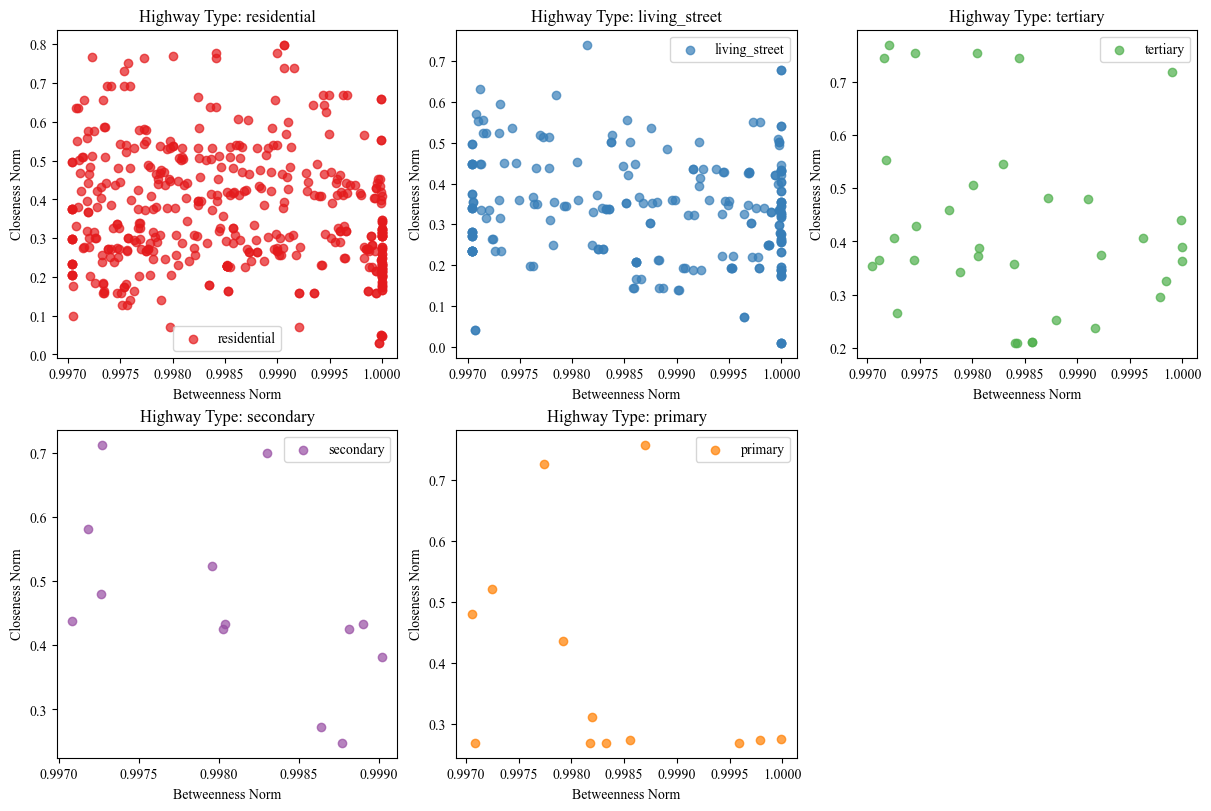

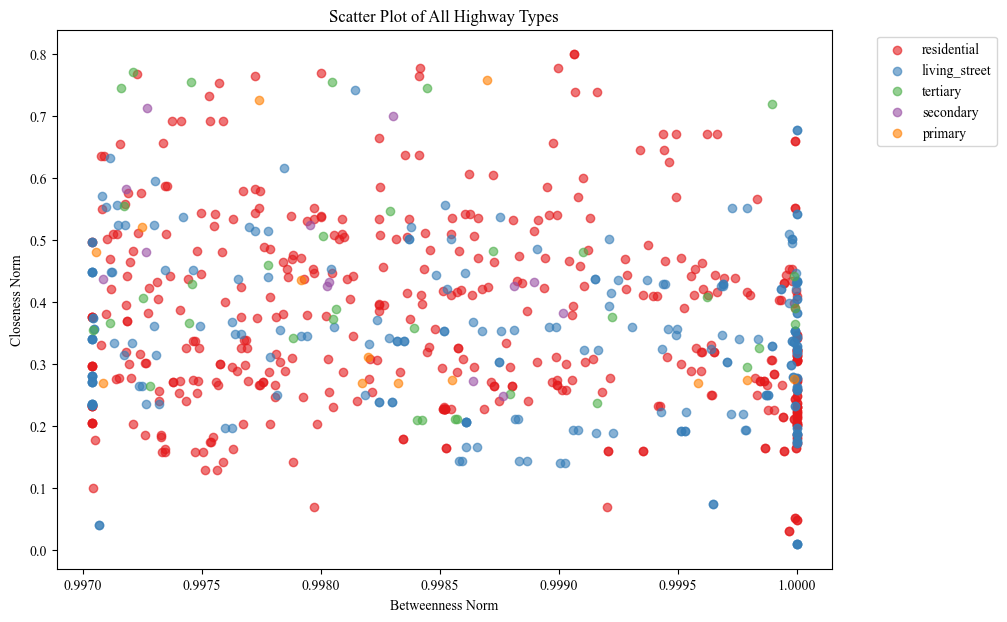

In [54]:
# Prepare data for plotting
betweenness_norms = []
closeness_norms = []
highway_types = []

# Collect the relevant data for each road
for road in high_closeness_low_betweenness_roads:
    betweenness_norms.append(road["betweenness_norm"])
    closeness_norms.append(road["closeness_norm"])

    highway = road["highway"]
    if "_link" in road["highway"]:
        highway = highway.replace("_link", "")

    highway_types.append(highway)

# Convert to numpy arrays
betweenness_norms = np.array(betweenness_norms)
closeness_norms = np.array(closeness_norms)
highway_types = np.array(highway_types)

# Get unique highway types
unique_highways = list(set(highway_types))
remove_values = {"['residential', 'living_street']", "unclassified"}
unique_highways = [hwy for hwy in unique_highways if hwy not in remove_values]
num_highways = len(unique_highways)

# Define subplot layout
cols = 3  # Number of columns in the grid
rows = (num_highways // cols) + (num_highways % cols > 0)  # Compute required rows

fig, axes = plt.subplots(rows, cols, figsize=(12, 4 * rows), constrained_layout=True)
axes = axes.flatten()  # Flatten axes array for easier iteration

# Generate scatter plot for each highway type
for i, highway in enumerate(unique_highways):
    ax = axes[i]

    # Filter data for the current highway type
    mask = highway_types == highway
    x = betweenness_norms[mask]
    y = closeness_norms[mask]

    # Plot scatter
    ax.scatter(x, y, alpha=0.7, label=highway, color=sns.color_palette("Set1")[i % 9])

    # Labels and title
    ax.set_xlabel("Betweenness Norm")
    ax.set_ylabel("Closeness Norm")
    ax.set_title(f"Highway Type: {highway}")
    ax.legend()

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Show plot
plt.show()

# Define color palette
palette = sns.color_palette("Set1", len(unique_highways))

# Plot all street types in one scatter plot
fig, ax = plt.subplots(figsize=(10, 7))

for i, highway in enumerate(unique_highways):
    mask = highway_types == highway
    x = betweenness_norms[mask]
    y = closeness_norms[mask]

    ax.scatter(x, y, alpha=0.6, label=highway, color=palette[i])

ax.set_xlabel("Betweenness Norm")
ax.set_ylabel("Closeness Norm")
ax.set_title("Scatter Plot of All Highway Types")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

plt.show()

We want the roads with high closeness centrality and low betweenness centrality. We have calculated the distance normalised, betweenness normalised and inverted. So we want the points to stay as close as possible to the upper right cone.
From the plot we can see that there are only a few types of motorways that have roads that meet the criteria: residential, residential, primary_link, tetiary. And residential are the most common type of high way in the top right corner

### Visualization of the positions of the roads that meet the criteria on the map

criteria_index = (betweenness norm + closeness norm) / 2

The higher the index the better

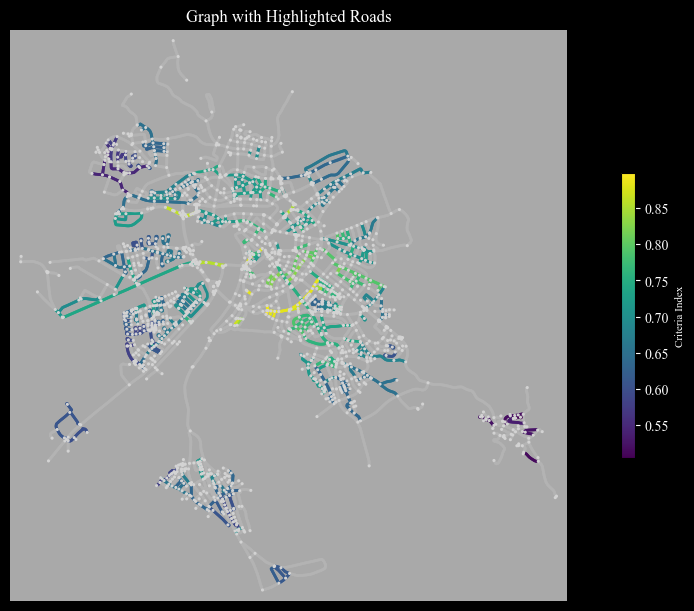

In [77]:
def plot_graph_with_road_colorbar(ax, G, roads_data):
    # Extract criteria index values for edges
    edge_values = []
    edge_colors = []
    
    for (u, v, data) in G.edges(data=True):
        # Find the corresponding road in roads_data
        matching_road = next((road for road in roads_data if 
                               road['name'] == data.get('name', '') and 
                               road['highway'] == data.get('highway', '')), 
                              None)
        
        if matching_road:
            # Color roads in the list with a viridis colormap based on criteria_index
            cmap = plt.cm.viridis
            norm = Normalize(vmin=min(road['criteria_index'] for road in roads_data), 
                             vmax=max(road['criteria_index'] for road in roads_data))
            edge_colors.append(cmap(norm(matching_road['criteria_index'])))
            edge_values.append(matching_road['criteria_index'])
        else:
            # Use a neutral gray color for roads not in the list
            edge_colors.append((0.7, 0.7, 0.7, 1))  # Light gray with full opacity
            edge_values.append(0)
    
    # Plot the graph
    ox.plot_graph(
        G,
        ax=ax,
        node_color="lightgray",
        edge_color=edge_colors,
        edge_linewidth=2,
        node_size=5,
        show=False,
        close=False,
    )
    
    ax.set_facecolor("darkgray")
    ax.set_title("Graph with Highlighted Roads", color="white")
    
    # Create a colorbar only for the roads in the list
    if roads_data:
        cmap = plt.cm.viridis
        norm = Normalize(vmin=min(road['criteria_index'] for road in roads_data), 
                         vmax=max(road['criteria_index'] for road in roads_data))
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = plt.colorbar(sm, shrink=0.5, ax=ax)
        cbar.set_label("Criteria Index", fontsize=8, color="white")
        cbar.ax.yaxis.set_tick_params(color="white")
        plt.setp(cbar.ax.get_yticklabels(), color="white")

# Example usage
fig, ax = plt.subplots(figsize=(12, 6), constrained_layout=True, facecolor="black")
plot_graph_with_road_colorbar(ax, G, high_closeness_low_betweenness_roads)
plt.show()